In [2]:
import subprocess
import sys

# Asegurar la instalación de pandas
try:
    import pandas as pd
except ImportError:
    print("pandas is not installed. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas", "--user"])
    import pandas as pd

# Asegurar la instalación de matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    print("matplotlib is not installed. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib", "--user"])
    import matplotlib.pyplot as plt

# Asegurar la instalación de ydata-profiling
try:
    from ydata_profiling import ProfileReport
except ImportError:
    print("ydata-profiling is not installed. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ydata-profiling", "--user"])
    from ydata_profiling import ProfileReport

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
dataset_path = os.path.join('data', 'used_cars_data.csv')

df=pd.read_csv(dataset_path)

In [4]:
df.head(3)

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50


In [20]:
print(type(df))

<class 'list'>


[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.625, 0.5, '  False')]

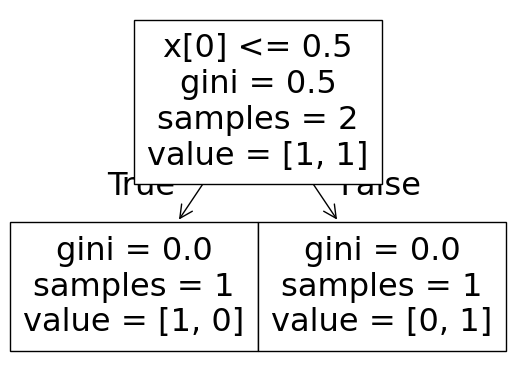

In [8]:
from sklearn import tree
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
tree.plot_tree(clf)

In [19]:
from sklearn import tree
X= df[["Kilometers_Driven","Seats"]] 
y = df=[["Year"]]  
clf= tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

TypeError: list indices must be integers or slices, not list